In [ ]:
import numpy as np
import pandas as pd

import os
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np

def load_data(base_dir, sample_n=50):
    all_data = []
    tickers_seen = set()

    for root, _, files in os.walk(base_dir):
        np.random.shuffle(files)
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, file)
                try:
                    # ticker z nazwy pliku
                    ticker = os.path.splitext(file)[0]
                    if ticker in tickers_seen:
                        continue

                    # wczytanie danych zgodnie z nowym formatem
                    df = pd.read_csv(path, skiprows=2, header=None,
                                     names=["Date", "Close", "High", "Low", "Open", "Volume"],
                                     usecols=["Date", "Close"])
                    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
                    df = df.dropna(subset=["Date", "Close"])

                    if df.shape[0] > 100:
                        df["TICKER"] = ticker
                        all_data.append(df)
                        tickers_seen.add(ticker)

                        if len(tickers_seen) >= sample_n:
                            break
                except Exception:
                    continue
        if len(tickers_seen) >= sample_n:
            break

    if not all_data:
        raise Exception("Brak danych")

    return pd.concat(all_data, ignore_index=True)


def prepare_pivot(df, start_year=2020, end_year=2025, max_nan_percent=5.0):
    df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    pivot = df.pivot(index="Date", columns="TICKER", values="Close").sort_index()
    pivot = pivot[pivot.index.weekday < 5]  # usuń weekendy
    nans = pivot.isna().sum() / len(pivot) * 100
    good_tickers = nans[nans <= max_nan_percent].index.tolist()
    pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
    return pivot



def extract_features(price_df: pd.DataFrame, window: int = 20):
    returns = price_df.pct_change().dropna()
    momentum = returns.tail(window).mean()
    volatility = returns.tail(window).std()
    sharpe = momentum / volatility
    cum_returns = (1 + returns.tail(window)).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    mdd = drawdown.min()
    corr_matrix = returns.tail(window).corr()
    total_corr = corr_matrix.sum() - 1
    features = pd.DataFrame({
        'MOM': momentum,
        'VOL': volatility,
        'SHARPE': sharpe,
        'MDD': mdd,
        'CORR': total_corr
    })
    return features.fillna(0)


def pso_fitness_advanced(weights, features,
                         lambda_mom=0.0, lambda_vol=0.4,
                         lambda_mdd=0.3, lambda_sharpe=0.2,
                         lambda_corr=0.1):
    port_mom = np.sum(weights * features["MOM"])
    port_vol = np.sqrt(np.sum((weights * features["VOL"])**2))
    port_sharpe = port_mom / port_vol if port_vol != 0 else 0
    port_mdd = np.sum(weights * features["MDD"])
    port_corr = np.sum(weights * features["CORR"])
    fitness = (
        - lambda_mom * port_mom +
        lambda_vol * port_vol +
        lambda_mdd * abs(port_mdd) -
        lambda_sharpe * port_sharpe +
        lambda_corr * port_corr
    )
    return fitness

def pso_optimize_advanced(features: pd.DataFrame,
                          n_particles=100, n_iterations=300, max_weight=0.2,
                          lambda_mom=0.0, lambda_vol=0.4,
                          lambda_mdd=0.3, lambda_sharpe=0.2,
                          lambda_corr=0.1):
    n_assets = len(features)
    particles = np.random.dirichlet(np.ones(n_assets), size=n_particles)
    velocities = np.zeros_like(particles)
    personal_best = particles.copy()
    personal_scores = np.array([
        pso_fitness_advanced(p, features,
                             lambda_mom, lambda_vol, lambda_mdd,
                             lambda_sharpe, lambda_corr)
        for p in particles
    ])
    global_best_idx = np.argmin(personal_scores)
    global_best = personal_best[global_best_idx].copy()

    for _ in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(n_assets), np.random.rand(n_assets)
            velocities[i] = 0.5 * velocities[i] + \
                            1.4 * r1 * (personal_best[i] - particles[i]) + \
                            1.4 * r2 * (global_best - particles[i])
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], 0, max_weight)
            particles[i] /= particles[i].sum() if particles[i].sum() > 0 else 1
            score = pso_fitness_advanced(particles[i], features,
                                         lambda_mom, lambda_vol,
                                         lambda_mdd, lambda_sharpe,
                                         lambda_corr)
            if score < personal_scores[i]:
                personal_best[i] = particles[i].copy()
                personal_scores[i] = score
                if score < personal_scores[global_best_idx]:
                    global_best = particles[i].copy()
                    global_best_idx = i

    return global_best

def realistic_pso_raw_advanced(pivoted_prices: pd.DataFrame,
                                feature_window: int = 20,
                                rebalance_period: int = 5,
                                n_particles: int = 100,
                                n_iterations: int = 300,
                                max_weight: float = 0.2,
                                lambda_mom: float = 0.0,
                                lambda_vol: float = 0.4,
                                lambda_mdd: float = 0.3,
                                lambda_sharpe: float = 0.2,
                                lambda_corr: float = 0.1,
                                fee_rate: float = 0.001):  # <- dodano fee_rate
    returns = pivoted_prices.pct_change().dropna()
    returns_test = returns[returns.index.year == 2025]
    dates = returns_test.index

    capital = 1.0
    capital_timeline = []
    weights_log = []
    shares = None
    prev_weights = pd.Series(0.0, index=pivoted_prices.columns)

    for start in range(0, len(dates), rebalance_period):
        end = min(start + rebalance_period, len(dates))
        rebalance_date = dates[start]
        period_dates = dates[start:end]
        current_prices = pivoted_prices.loc[rebalance_date]

        price_history = pivoted_prices.loc[:rebalance_date].tail(feature_window + 1)
        features = extract_features(price_history, window=feature_window)

        new_weights = pso_optimize_advanced(
            features,
            n_particles=n_particles,
            n_iterations=n_iterations,
            max_weight=max_weight,
            lambda_mom=lambda_mom,
            lambda_vol=lambda_vol,
            lambda_mdd=lambda_mdd,
            lambda_sharpe=lambda_sharpe,
            lambda_corr=lambda_corr
        )

        # --- Oblicz wartość portfela przed rebalancingiem ---
        total_value = (shares * current_prices).sum() if shares is not None else capital

        # --- Koszty transakcyjne ---
        cost = fee_rate * total_value * np.sum(np.abs(new_weights - prev_weights))
        total_value_after_cost = total_value - cost
        capital = total_value_after_cost  # aktualizacja kapitału

        # --- Oblicz liczby udziałów ---
        shares = (new_weights * total_value_after_cost) / current_prices
        prev_weights = new_weights

        for date in period_dates:
            prices_today = pivoted_prices.loc[date]
            portfolio_value = np.sum(shares * prices_today)
            capital_timeline.append((date, portfolio_value))

        for ticker, w in zip(pivoted_prices.columns, new_weights):
            weights_log.append({
                "Date": rebalance_date,
                "Ticker": ticker,
                "Weight": w
            })

    capital_series = pd.Series(dict(capital_timeline))
    weights_df = pd.DataFrame(weights_log)
    return capital_series, weights_df


In [ ]:
def generate_stress_data(pivoted: pd.DataFrame, periods: dict) -> pd.DataFrame:
 
    stress_data_segments = []
    for label, (start, end) in periods.items():
        segment = pivoted.loc[start:end].pct_change().dropna()
        segment["SCENARIO"] = label
        stress_data_segments.append(segment)
    combined = pd.concat(stress_data_segments).dropna(axis=1)
    return combined


def generate_bootstrap_stress_paths(returns_df: pd.DataFrame,
                                     path_length: int = 21,
                                     n_paths: int = 5,
                                     block_size: int = 5) -> list:
  
    returns_df = returns_df.drop(columns=["SCENARIO"], errors="ignore")
    returns_df = returns_df.dropna(axis=1)

    block_starts = np.arange(len(returns_df) - block_size + 1)
    paths = []

    for _ in range(n_paths):
        idx = np.random.choice(block_starts, size=(path_length // block_size + 1), replace=True)
        sampled_blocks = [returns_df.iloc[i:i + block_size] for i in idx]
        sampled_path = pd.concat(sampled_blocks).iloc[:path_length]
        paths.append(sampled_path.reset_index(drop=True))

    return paths


extended_stress_periods = {
    "COVID_crash": ("2020-02-20", "2020-04-30"),
    "Post_COVID_bubble_burst": ("2022-01-01", "2022-07-31"),
    "Ukraine_war": ("2022-02-24", "2022-05-30"),
    "Inflation_rate_spike": ("2022-06-01", "2022-10-31"),
    "SVB_Crisis": ("2023-03-01", "2023-04-15"),
    "Mini_crash_2018": ("2018-10-01", "2018-12-31"),
    "Fed_hike_shock_2018": ("2018-01-25", "2018-03-30"),
    "China_stock_crash": ("2015-06-15", "2015-09-30"),
    "China_currency_devaluation": ("2015-08-01", "2015-10-31"),
    "Oil_price_crash": ("2014-09-01", "2015-01-30"),
    "Taper_tantrum": ("2013-05-01", "2013-07-31"),
    "EU_sovereign_crisis": ("2011-07-01", "2011-10-31"),
    "Flash_crash": ("2010-05-06", "2010-05-31"),
    "Debt_ceiling_2011": ("2011-08-01", "2011-08-31"),
    "Greek_crisis_2010": ("2010-04-01", "2010-07-01")
}


In [3]:
df_all = load_data(r"C:\Users\Basia\Do przejrzenia\am_sem2\mgr\kody\downloaded_data", sample_n=771)
pivoted = prepare_pivot(df_all)


C:\Users\Basia\AppData\Local\Temp\ipykernel_2296\97741705.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")


In [ ]:
def generate_statistical_stress_periods(pivoted_prices: pd.DataFrame,
                                        window: int = 20,
                                        volatility_quantile: float = 0.95,
                                        min_period_length: int = 5) -> dict:

    # 1. Zwroty logarytmiczne portfela rynkowego
    log_returns = np.log(pivoted_prices / pivoted_prices.shift(1)).dropna()
    portfolio_returns = log_returns.mean(axis=1)

    # 2. Rolling volatility 
    rolling_vol = portfolio_returns.rolling(window).std()

    # 3. Próg wysokiej zmienności 
    vol_threshold = rolling_vol.quantile(volatility_quantile)

    # 4. Wybór dni o wysokiej zmienności
    high_vol_days = rolling_vol[rolling_vol > vol_threshold].index

    # 5. Grupowanie dni w ciągłe okresy 
    stress_periods = []
    if not high_vol_days.empty:
        current_start = high_vol_days[0]
        current_end = high_vol_days[0]

        for date in high_vol_days[1:]:
            if (date - current_end).days <= 3:
                current_end = date
            else:
                if (current_end - current_start).days + 1 >= min_period_length:
                    stress_periods.append((current_start, current_end))
                current_start = date
                current_end = date

        # ostatni przedział
        if (current_end - current_start).days + 1 >= min_period_length:
            stress_periods.append((current_start, current_end))

    stress_dict = {
        f"StatStress_{i+1}": (start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
        for i, (start, end) in enumerate(stress_periods)
    }

    return stress_dict


In [6]:
statistical_stress_periods = generate_statistical_stress_periods(pivoted, window=5, volatility_quantile=0.5)

stress_data = generate_stress_data(pivoted, statistical_stress_periods)
stress_data

c:\Users\Basia\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


TICKER,1COV.DE,AAL.L,AAPL,ABBN.SW,ABBV,ABEV,ABEV3.SA,ABG.JO,ABX.TO,ACA.PA,...,^FTSE,^GDAXI,^GSPC,^GSPTSE,^IBEX,^MXX,^NDX,^RUT,^STOXX50E,SCENARIO
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-28,0.015754,0.009840,0.028289,0.002653,-0.002975,0.022831,0.013477,0.007299,-0.035816,0.010953,...,0.009255,0.009006,0.010054,0.003348,0.012588,0.013222,0.015499,0.008619,0.011251,StatStress_1
2020-01-29,0.003559,-0.002436,0.020932,0.015432,-0.006805,-0.046875,-0.026596,0.007247,0.023217,-0.002006,...,0.000388,0.001599,-0.000867,0.000623,0.006590,0.009273,0.001175,-0.005482,0.004609,StatStress_1
2020-01-30,-0.010894,-0.008059,-0.001449,-0.013461,-0.017068,0.000000,0.002186,0.006115,0.003713,-0.012465,...,-0.013576,-0.014079,0.003134,-0.001211,-0.007207,-0.005979,0.003788,-0.000606,-0.012199,StatStress_1
2020-01-31,-0.022797,-0.022354,-0.044339,-0.009243,-0.009293,-0.025761,-0.026717,-0.017233,0.007398,-0.004072,...,-0.013005,-0.013312,-0.017706,-0.009840,-0.011606,-0.016817,-0.015825,-0.020725,-0.013512,StatStress_1
2020-02-03,-0.011271,0.003425,-0.002746,0.004887,0.015799,-0.007212,-0.014566,0.001164,-0.007752,0.008994,...,0.005531,0.004870,0.007255,0.003540,0.003928,0.000000,0.014983,0.011245,0.005592,StatStress_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-24,0.000000,0.026679,0.018426,0.003320,0.018752,0.004082,0.007117,0.009853,0.016245,0.000000,...,0.000500,0.004669,0.020259,0.010412,-0.002165,0.011036,0.027879,0.020035,0.003185,StatStress_49
2025-04-25,0.000000,-0.003248,0.004367,0.022217,0.031546,0.004065,-0.004240,0.000654,-0.018216,0.011384,...,0.000940,0.008065,0.007373,-0.000687,0.013323,0.005997,0.011354,0.000015,0.007652,StatStress_49
2025-04-28,0.001695,-0.017225,0.004109,0.003237,0.033753,0.008097,0.014904,0.000000,0.009466,0.014514,...,0.000238,0.001314,0.000641,0.003565,0.007548,0.004584,-0.000271,0.004051,0.003176,StatStress_49


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

n_iterations = 100
path_length = 22
block_size = 5
output_dir = "rolling_results_raw2/"
os.makedirs(output_dir, exist_ok=True)


statistical_stress_periods = generate_statistical_stress_periods(
    pivoted_prices=pivoted,
    window=5,
    volatility_quantile=0.5,
    min_period_length=5
)


stress_data_real = generate_stress_data(pivoted, statistical_stress_periods)
sample_columns = pivoted.columns
last_prices = pivoted.loc[pivoted.index < "2025-05-01"].iloc[-1]
historical_prices = pivoted.copy()

results = []

for i in tqdm(range(n_iterations), desc="Rolling stress test iterations - PSO RAW"):

    stress_paths = generate_bootstrap_stress_paths(
        stress_data_real[sample_columns],
        path_length=path_length,
        n_paths=1,
        block_size=block_size
    )
    stress_path = stress_paths[0]


    stress_prices = pd.DataFrame(
        data=np.cumprod(1 + stress_path.values, axis=0) * last_prices.values,
        columns=sample_columns,
        index=pd.date_range(start="2025-05-01", periods=path_length, freq="B")
    )


    capital_series, weights_df = realistic_pso_raw_advanced(
        pivoted_prices=stress_prices,
        feature_window=20,
        rebalance_period=5,
        n_particles=200,
        n_iterations=300,
        max_weight=0.15,
        lambda_mom=0.2,
        lambda_vol=0.3,
        lambda_mdd=0.3,
        lambda_sharpe=0.3,
        lambda_corr=0.3 
    )

    capital_series.to_csv(f"{output_dir}/capital_iteration_{i+1}.csv")
    weights_df.to_csv(f"{output_dir}/weights_iteration_{i+1}.csv")
    results.append(capital_series)


capital_series_combined = pd.concat(results, axis=1)


c:\Users\Basia\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
Rolling stress test iterations - PSO RAW: 100%|██████████| 100/100 [14:55:15<00:00, 537.15s/it] 


<Axes: title={'center': 'Kapitał w czasie - PSO RAW z okresami stresowymi'}>

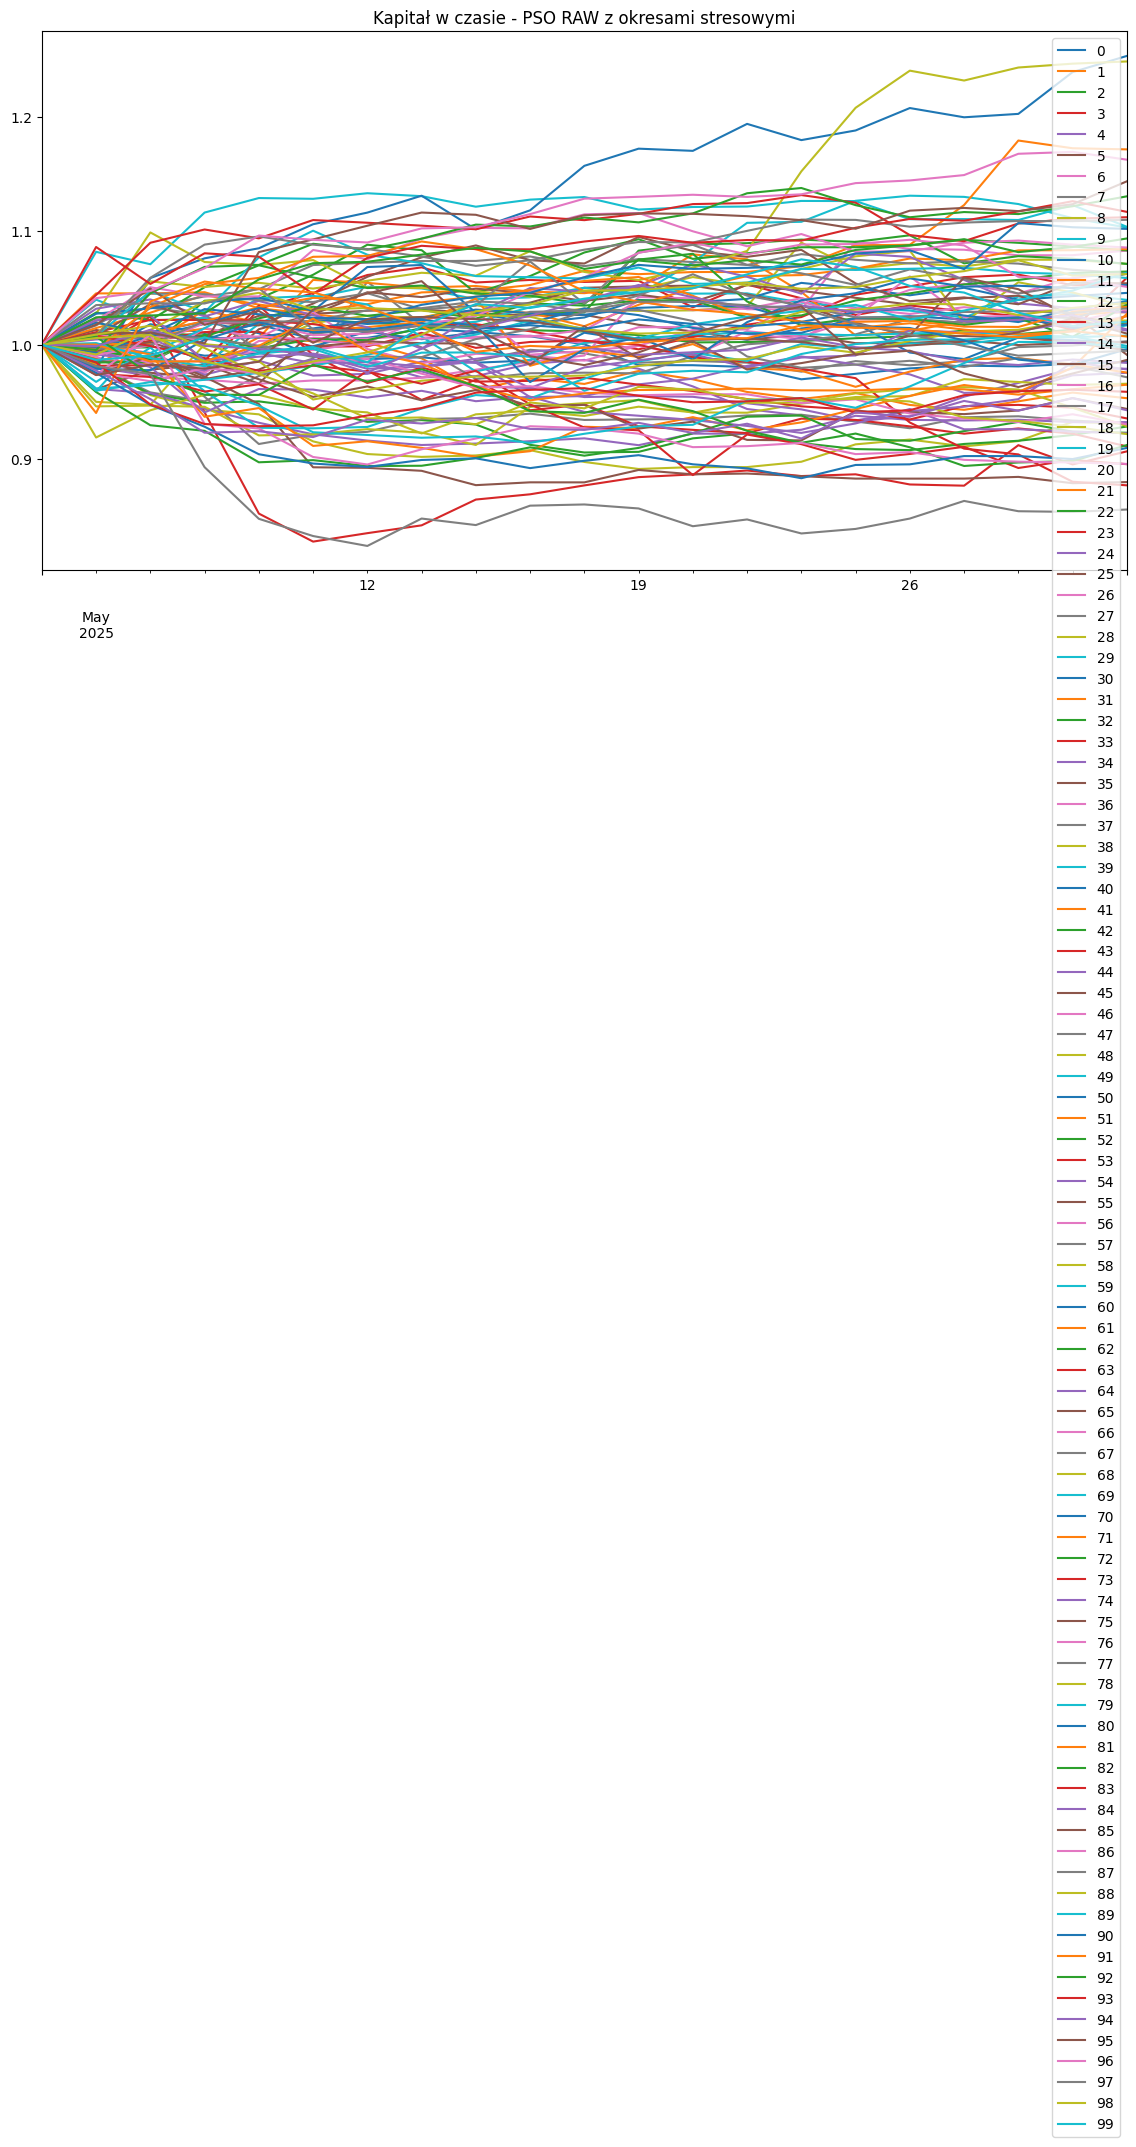

In [9]:
capital_series_combined.plot(figsize=(14, 7), title="Kapitał w czasie - PSO RAW z okresami stresowymi")